# Diagnostics: bias map

In this first diagnostic example, you will discover what a diagnostic is, how it is calculated and what other rich library of functions lies behind. 
We'll do this with the simple example of creating a bias map. 


### 0. Loading packages

In [19]:
import valenspy as vp
from pathlib import Path
import xarray as xr
from matplotlib import pyplot as plt

## 1. Input
Loading of the different input datasets, just as in the previous notebooks but now more condensed. 

In [22]:
machine = 'hortense' #'tier2_VO_geo' # define the machine name

manager = vp.InputManager(machine=machine) #Create the input manager

# load climate grid data
ds_climate_grid = manager.load_data("CLIMATE_GRID", variables=["tas"], path_identifiers=["latlon_5km"])

# load ERA5 data
ds_ERA5 = manager.load_data("ERA5", variables=["tas"], period=[2018], freq="hourly")


File paths found:
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-2018.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


## 2. Preprocessing

Preprocessing steps necessary for the bias maps. 

In [ ]:
ds_climate_grid_remap = ds_ERA5_dail

<xarray.Dataset> Size: 12MB
Dimensions:  (time: 31, lon: 289, lat: 163)
Coordinates:
  * time     (time) datetime64[ns] 248B 2018-07-01 2018-07-02 ... 2018-07-31
  * lon      (lon) float32 1kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * lat      (lat) float32 652B 33.0 33.25 33.5 33.75 ... 72.75 73.0 73.25 73.5
Data variables:
    tas      (time, lat, lon) float64 12MB dask.array<chunksize=(31, 163, 289), meta=np.ndarray>
Attributes: (12/13)
    CDI:               Climate Data Interface version 2.2.1 (https://mpimet.m...
    Conventions:       CF-1.6
    creation_date:     25-06-2024
    creators:          Ghilain N., Van Schaeybroeck B., Vanderkelen I.
    contact:           inne.vanderkelen@meteo.be
    version:           1.1
    ...                ...
    projection:        +proj=lcc +lat_2=50.569898649999999 +lat_1=50.56989864...
    history:           Thu Nov 07 19:46:32 2024: cdo -O -s -f nc -remapcon,/d...
    path_identifiers:  latlon_5km
    dataset:           CLIMATE_GRID
    freq:              hourly
    CDO:               Climate Data Operators version 2.2.0 (https://mpimet.m...

In [29]:
## 2.1 Selecting a time period
ds_climate_grid = ds_climate_grid.sel(time='07-2018').compute() #Select the month of July 2018
ds_ERA5 = ds_ERA5.sel(time='07-2018') #Select the month of July 2018


## 2.2 Resampling to the same frequency
ds_ERA5_daily = ds_ERA5.resample(time='1D').mean().compute()#Resample the data to daily values
ds_ERA5_daily

## 2.3 Regridding
gridfile = manager._get_file_paths("ERA5", variables=["tas"], period=[2018,2018], freq="hourly")[0]
ds_climate_grid_remap = vp.remap_cdo(gridfile, ds_climate_grid, remap_method="con").compute() # Remapping the ERA5 data to the CLIMATE_GRID grid - NOTE this uses CDO

## 2.4 domain selection
# Mask the ERA5 data with the CLIMATE_GRID by selecting only those values where there are temperature observations 
ds_ERA5_daily = ds_ERA5_daily.where(ds_climate_grid_remap.tas.notnull(), drop=True)
ds_climate_grid_remap = ds_climate_grid_remap.where(ds_climate_grid_remap.tas.notnull(), drop=True)


# save the datasets in easier names to work with in the diagnostics
ds_ERA5 = ds_ERA5_daily
ds_climate_grid = ds_climate_grid_remap


## 3. Diagnostic

Time for the fun part, selecting and playing with diagnostics!

### 3.1 Diagnostics  through the diagnostic object

We will start with the highest level: the diagnostic object. This is the most basic interface to get output from Valenspy

In [ ]:
from valenspy.diagnostic import SpatialBias
print(SpatialBias.description)

Spatial Bias (Model2Ref)
The spatial bias of the data compared to the reference.
 Diagnostic function: spatial_bias
 Calculate the spatial bias of the data compared to the reference. The time dimensions are averaged over if present.

    Parameters
    ----------
    ds : xr.Dataset
        The data to calculate the spatial bias of.
    ref : xr.Dataset or xr.DataArray
        The reference data to compare the data to.
    calc_relative : bool, optional
        If True, return the relative bias, if False return the absolute bias, by default False

    Returns
    -------
    xr.Dataset or xr.DataArray
        The spatial bias of the data compared to the reference.
    
 Visualization function: plot_spatial_bias
 
    Plot the spatial bias of a given data array on a map.

    Parameters
    ----------
    da : xarray.DataArray
        The DataArray containing the bias data to be plotted. It is assumed that the data represents some
        form of spatial bias, and the plot will visualiz

This diagnostic object uses underlying functions to calculate the mean bias over the time dimension based on the two inputs. It returns a dataset with the resulting calculation. Let's check it out. 

In [ ]:
ds_spatialbias = SpatialBias.apply(ds_climate_grid, ref=ds_ERA5).compute() #As this is a dask array, nothing is computed until we call the compute method
ds_spatialbias

NameError: name 'SpatialBias' is not defined

Note there is no time dimension anymore! As we have calculated the mean over the time dimension.

Each diagnostic has a predefined plot function. Let's use it to plot the bias map for the variable tas.

AttributeError: Line2D.set() got an unexpected keyword argument 'cbar_kwargs'

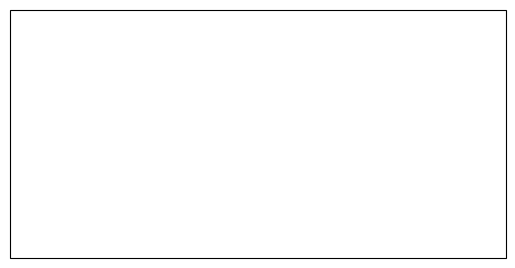

In [ ]:
SpatialBias.plot(ds_spatialbias.tas)
plt.show()

Another example of a diagnostic is the Temporal bias, or the spatial mean over time plotted. Let's calculate and plot that diagnostic!


<Axes: title={'left': 'Near-Surface Air Temperature', 'center': ' '}, xlabel='time', ylabel='Near-Surface Air Temperature\n[K]'>

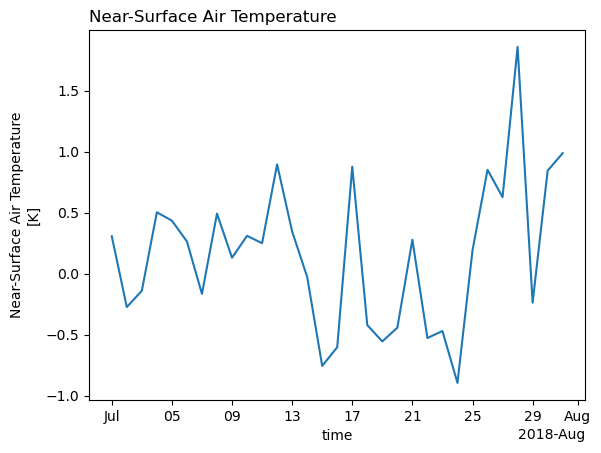

In [ ]:
from valenspy.diagnostic import TemporalBias

ds_temporalbias = TemporalBias.apply(ds_climate_grid, ref=ds_ERA5).compute() #As this is a dask array, nothing is computed until we call the compute method
TemporalBias.plot(ds_temporalbias.tas)


Yes, it is that simple! 


The availability of other diagnostics can be checked here (Kobe can you help here how to list the diagnostics? ) This list will definitely grow in the future. 

### 3.2 Advanced: accessing diagnostic functions and visualization functions directly 

Under the hood, the diagnostic object is using diagnostic functions. As a user, you can also use them directly. These are available in the diagnostic [functions](./../../src/valenspy/diagnostic/functions.py) and [visulalizations](./../../src/valenspy/diagnostic/visualizations.py) python files. 

Let's take our same example again and calculate the spatial bias using function itself. 

In [ ]:
# we need to load the function
from valenspy.diagnostic.functions import spatial_bias

help(spatial_bias)

Help on function spatial_bias in module valenspy.diagnostic.functions:

spatial_bias(ds: xarray.core.dataset.Dataset, ref: xarray.core.dataset.Dataset, calc_relative=False)
    Calculate the spatial bias of the data compared to the reference. The time dimensions are averaged over if present.
    
    Parameters
    ----------
    ds : xr.Dataset
        The data to calculate the spatial bias of.
    ref : xr.Dataset or xr.DataArray
        The reference data to compare the data to.
    calc_relative : bool, optional
        If True, return the relative bias, if False return the absolute bias, by default False
    
    Returns
    -------
    xr.Dataset or xr.DataArray
        The spatial bias of the data compared to the reference.



In [ ]:
ds_spatialbias_2 = spatial_bias(ds_climate_grid, ref=ds_ERA5)
ds_spatialbias_2

<xarray.Dataset> Size: 40B
Dimensions:  (lon: 2, lat: 1)
Coordinates:
  * lon      (lon) float64 16B 3.75 5.5
  * lat      (lat) float64 8B 51.25
Data variables:
    tas      (lat, lon) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/13)
    CDI:               Climate Data Interface version 2.2.1 (https://mpimet.m...
    Conventions:       CF-1.6
    creation_date:     25-06-2024
    creators:          Ghilain N., Van Schaeybroeck B., Vanderkelen I.
    contact:           inne.vanderkelen@meteo.be
    version:           1.1
    ...                ...
    projection:        +proj=lcc +lat_2=50.569898649999999 +lat_1=50.56989864...
    history:           Thu Nov 07 19:30:26 2024: cdo -O -s -f nc -remapcon,/d...
    path_identifiers:  latlon_5km
    dataset:           CLIMATE_GRID
    freq:              hourly
    CDO:               Climate Data Operators version 2.2.0 (https://mpimet.m...

Now plot the spatial bias with an even more advanced plotting function, showing nicely the differences between both: 

AttributeError: Line2D.set() got an unexpected keyword argument 'cmap'

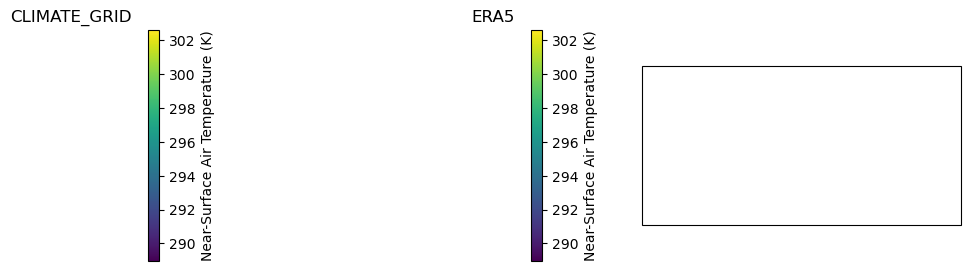

In [ ]:
from valenspy.diagnostic.visualizations import plot_maps_mod_ref_diff

plot_maps_mod_ref_diff(ds_climate_grid.tas,ds_ERA5.tas, ds_spatialbias_2.tas)



### 3.3 Bonus 

As a bonus, an additional simple mapping function! 

AttributeError: Line2D.set() got an unexpected keyword argument 'cbar_kwargs'

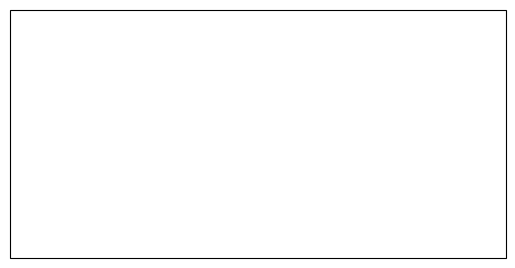

In [11]:
from valenspy.diagnostic.visualizations import plot_map

plot_map(ds_ERA5['tas'].mean('time'), title="ERA5 temperature", region='belgium')

To add at later stage: all functionalities of the mapping functions: predefined regions, ax objects, controlling own plots etc!